In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats 
import matplotlib.pyplot as plt
import seaborn as sns

import folium
from folium.plugins import HeatMap
import geopandas as gpd

SEED = 123
np.random.seed(SEED)

In [23]:
# load the restaurant details data with 'restaurant_details.csv' generated from 'data_processing.ipynb'
df_details = pd.read_csv('restaurant_details_michelin_stars.csv', index_col=0)
df_details

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,transactions,...,category_3,is_michelin,reviews_cnt,elite_reviews_cnt,elite_reviews_perc,user_photo_cnt_avg,user_review_cnt_avg,rating_avg,rating_med,rating_std
0,ce605OMECZ3jLZtk6dCDHA,le-pain-quotidien-new-york-137,Le Pain Quotidien,https://s3-media3.fl.yelpcdn.com/bphoto/z-YqDX...,False,https://www.yelp.com/biz/le-pain-quotidien-new...,84,"[{'alias': 'coffee', 'title': 'Coffee & Tea'},...",3.0,"['pickup', 'delivery']",...,NaN,0,50,16,0.320000,755.900000,199.860000,3.320000,4.0,1.531173
1,B8yFj4qt-HgMCbF5S-GkgA,creperie-new-york-6,Creperie,https://s3-media1.fl.yelpcdn.com/bphoto/uydGkc...,False,https://www.yelp.com/biz/creperie-new-york-6?a...,19,"[{'alias': 'creperies', 'title': 'Creperies'}]",2.5,[],...,NaN,0,19,1,0.052632,654.894737,244.842105,2.631579,2.0,1.300022
2,WZLhPYaYSFy7M_-Jh1VuNw,dos-toros-taqueria-new-york-5,Dos Toros Taqueria,https://s3-media1.fl.yelpcdn.com/bphoto/fNdfBJ...,False,https://www.yelp.com/biz/dos-toros-taqueria-ne...,132,"[{'alias': 'mexican', 'title': 'Mexican'}]",3.5,[],...,NaN,0,50,24,0.480000,3183.000000,365.740000,4.040000,4.0,1.159873
3,tFQRwk9SVOFgpMBZ55UrLw,umami-burger-new-york-17,Umami Burger,https://s3-media2.fl.yelpcdn.com/bphoto/uvquI3...,False,https://www.yelp.com/biz/umami-burger-new-york...,333,"[{'alias': 'burgers', 'title': 'Burgers'}]",3.0,"['delivery', 'pickup']",...,NaN,0,50,34,0.680000,941.800000,424.520000,3.240000,3.5,1.378553
4,jhs35REmv8Yo9-Z27KQJSA,naya-brookfield-place-new-york-3,NAYA - Brookfield Place,https://s3-media3.fl.yelpcdn.com/bphoto/Zd6LgX...,False,https://www.yelp.com/biz/naya-brookfield-place...,32,"[{'alias': 'mediterranean', 'title': 'Mediterr...",4.5,"['pickup', 'delivery']",...,NaN,0,32,15,0.468750,603.875000,252.406250,4.250000,5.0,1.077632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10872,J0V2C6wAkHMLD9j7I50_ZQ,sgd-dubu-so-gong-dong-tofu-and-bbq-edgewater-2,SGD Dubu So Gong Dong Tofu & BBQ,https://s3-media3.fl.yelpcdn.com/bphoto/xX4DnY...,False,https://www.yelp.com/biz/sgd-dubu-so-gong-dong...,228,"[{'alias': 'korean', 'title': 'Korean'}, {'ali...",4.0,['delivery'],...,NaN,0,50,28,0.560000,979.220000,312.580000,3.860000,4.0,1.143036
10873,awvl9pC0RW8PT5A3NeLGMg,fuxingmei-sushi-house-edgewater,FuXingMei Sushi House,https://s3-media1.fl.yelpcdn.com/bphoto/ZgikoA...,False,https://www.yelp.com/biz/fuxingmei-sushi-house...,94,"[{'alias': 'japanese', 'title': 'Japanese'}, {...",4.0,"['delivery', 'pickup']",...,NaN,0,50,16,0.320000,609.660000,186.440000,4.000000,4.0,1.195229
10874,JmhZW6euOW_7L3E3v4fpKg,happy-wok-bronx,Happy Wok,NaN,False,https://www.yelp.com/biz/happy-wok-bronx?adjus...,6,"[{'alias': 'chinese', 'title': 'Chinese'}]",2.0,"['delivery', 'pickup']",...,NaN,0,6,0,0.000000,1.833333,5.833333,2.166667,1.0,1.834848
10875,S55v4pq633nTz7jbGmrCfg,justins-pizza-bronx,Justin's Pizza,https://s3-media2.fl.yelpcdn.com/bphoto/CH79G2...,False,https://www.yelp.com/biz/justins-pizza-bronx?a...,18,"[{'alias': 'pizza', 'title': 'Pizza'}, {'alias...",2.5,"['delivery', 'pickup']",...,NaN,0,18,1,0.055556,3847.222222,312.888889,2.611111,2.0,1.685191


# Michelin Restaurant Profile - Visualizaion

### Geomap

In [24]:
# Create a map centered around New York City
nyc_coordinates = (40.7128, -74.0060)  # Latitude and Longitude of NYC
nyc_map = folium.Map(location=nyc_coordinates, zoom_start=12)

michelin_df = df_details[df_details['is_michelin'] == True]

# Iterate over the Michelin-starred restaurant DataFrame
for _, row in michelin_df.iterrows():
    # Define the popup message including name, categories, ratings, and price
    categories = ', '.join([str(row[f'category_{i}']) for i in range(4) if row[f'category_{i}'] is not None])

    popup_message = folium.Popup((f"{row['name']}\n"
                                  f"Cuisine: {categories}\n"
                                  f"Rating: {row['rating']}\n"
                                  f"Price: {row['price']}"),
                                  parse_html=False)

    # Create a marker and add it to the map
    folium.Marker(
        location=(row['coordinates.latitude'], row['coordinates.longitude']),
        popup=popup_message,
        icon=folium.Icon(color='red', icon='star')
    ).add_to(nyc_map)

# Display the map
nyc_map

### Heatmap wrt Price

In [25]:
## Heat map does not work well in general because of large variability in restaurant data, 
## but it provides some insights into regional restaurant information
# Preprocess Data: Convert price to numerical values
price_mapping = {'$': 1, '$$': 2, '$$$': 3, '$$$$': 4}
df_details['price_numeric'] = df_details['price'].map(price_mapping)

# Remove rows with missing data
df_details = df_details.dropna(subset=['coordinates.latitude', 'coordinates.longitude', 'review_count'])

# Create a base map
nyc_coordinates = (40.7128, -74.0060)
nyc_map = folium.Map(location=nyc_coordinates, zoom_start=12)

# Prepare data for the heatmap
heat_data = [[row['coordinates.latitude'], row['coordinates.longitude'], row['review_count']]
             for index, row in df_details.iterrows()]

# Add heatmap to the map
HeatMap(heat_data).add_to(nyc_map)

# Display the map
nyc_map


### A Closer Look at Location Distribution of Michelin vs Non-Michelin

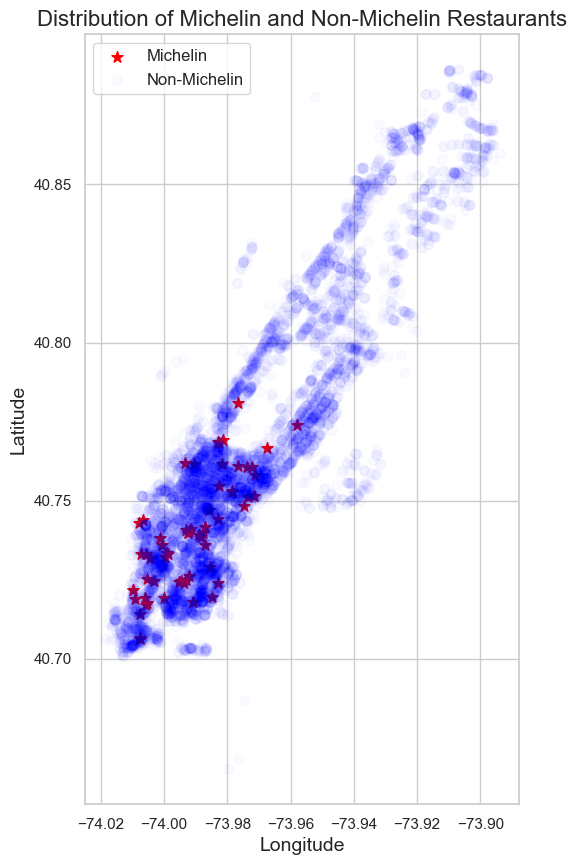

In [26]:
gdf = gpd.GeoDataFrame(
    df_details, 
    geometry=gpd.points_from_xy(df_details['coordinates.longitude'], df_details['coordinates.latitude'])
)

fig, ax = plt.subplots(figsize=(10, 10))
michelin_base = gdf[gdf['is_michelin'] == 1].plot(ax=ax, markersize=70, color='red', label='Michelin', marker='*')
gdf[gdf['is_michelin'] == 0].plot(ax=michelin_base, markersize=50, color='blue', label='Non-Michelin', alpha=0.02, marker='o')

ax.legend(prop={'size': 12})
ax.set_title('Distribution of Michelin and Non-Michelin Restaurants', fontsize=16)
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
ax.grid(True)
plt.show()


### Distribution of Michelin-Starred Restaurants by Cuisine/Category

AttributeError: Rectangle.set() got an unexpected keyword argument 'legend'

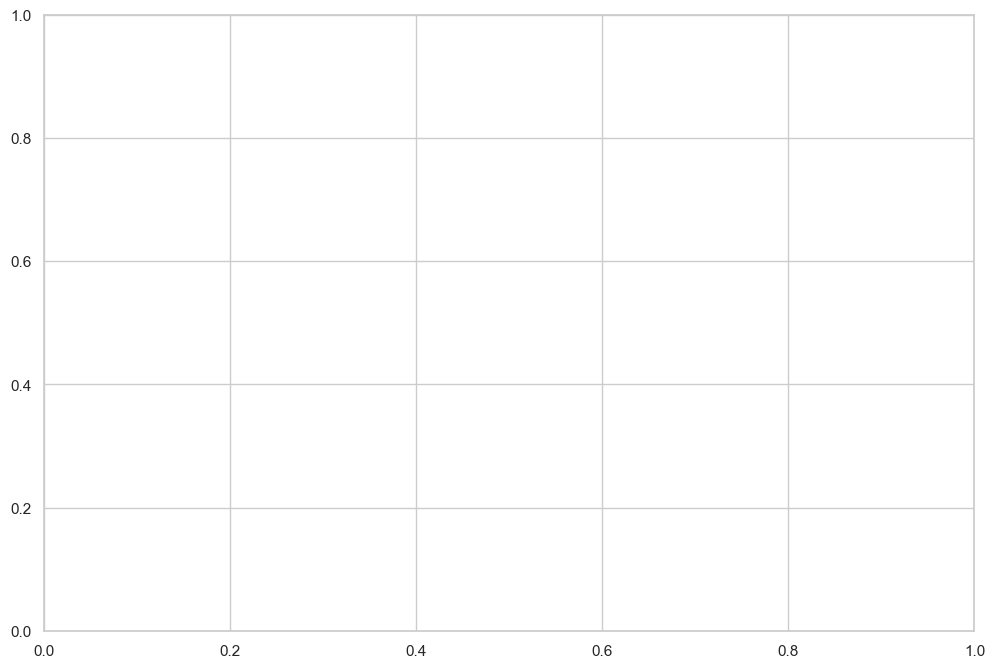

In [27]:
melted_michelin_df = michelin_df.melt(id_vars=["id", "name"], value_vars=["category_0", "category_1", "category_2", "category_3"], var_name="category_type", value_name="category").dropna()

# Counting the occurrences of each category
category_counts = melted_michelin_df['category'].value_counts()

sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=category_counts.index, y=category_counts.values, hue=category_counts.index, palette="coolwarm", legend=False)


plt.title('Distribution of Michelin Restaurants by Category', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Number of Restaurants', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate and align labels to the right for better readability

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=12, color='black',
                xytext=(0, 5),
                textcoords='offset points')
    
plt.tight_layout()
plt.show()

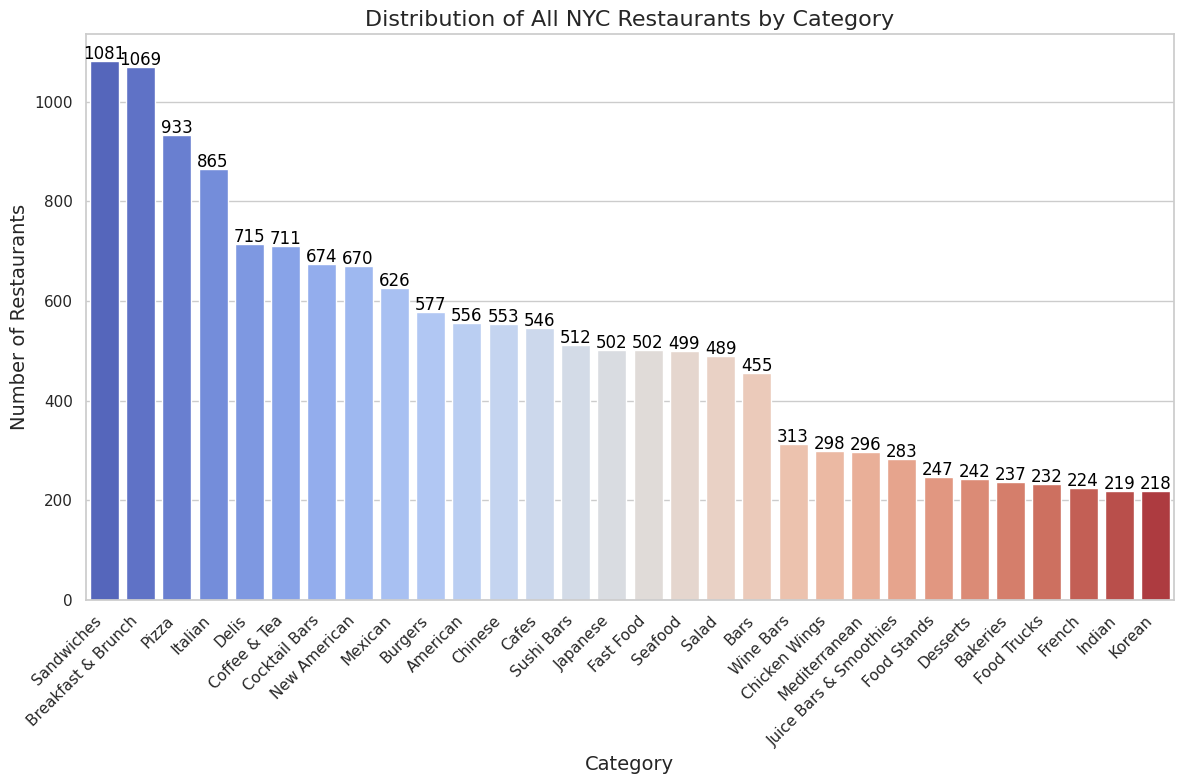

In [7]:
melted_all_df = df_details.melt(id_vars=["id", "name"], value_vars=["category_0", "category_1", "category_2", "category_3"], var_name="category_type", value_name="category").dropna()

# Counting the occurrences of each category
category_counts = melted_all_df['category'].value_counts().head(30)

sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=category_counts.index, y=category_counts.values, hue=category_counts.index, palette="coolwarm", legend=False)


plt.title('Distribution of All NYC Restaurants by Category', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Number of Restaurants', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate and align labels to the right for better readability

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=12, color='black',
                xytext=(0, 5),
                textcoords='offset points')
    
plt.tight_layout()
plt.show()

### Comparison of Michelin-Starred Restaurants vs Non-Michelin Restaurants by Category

/var/folders/kj/3n05xf5101nd06t7q93vbtnc0000gn/T/ipykernel_4385/1532839210.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  melted_all_df_sorted['category'] = pd.Categorical(melted_all_df_sorted['category'], categories=sorted_categories, ordered=True)


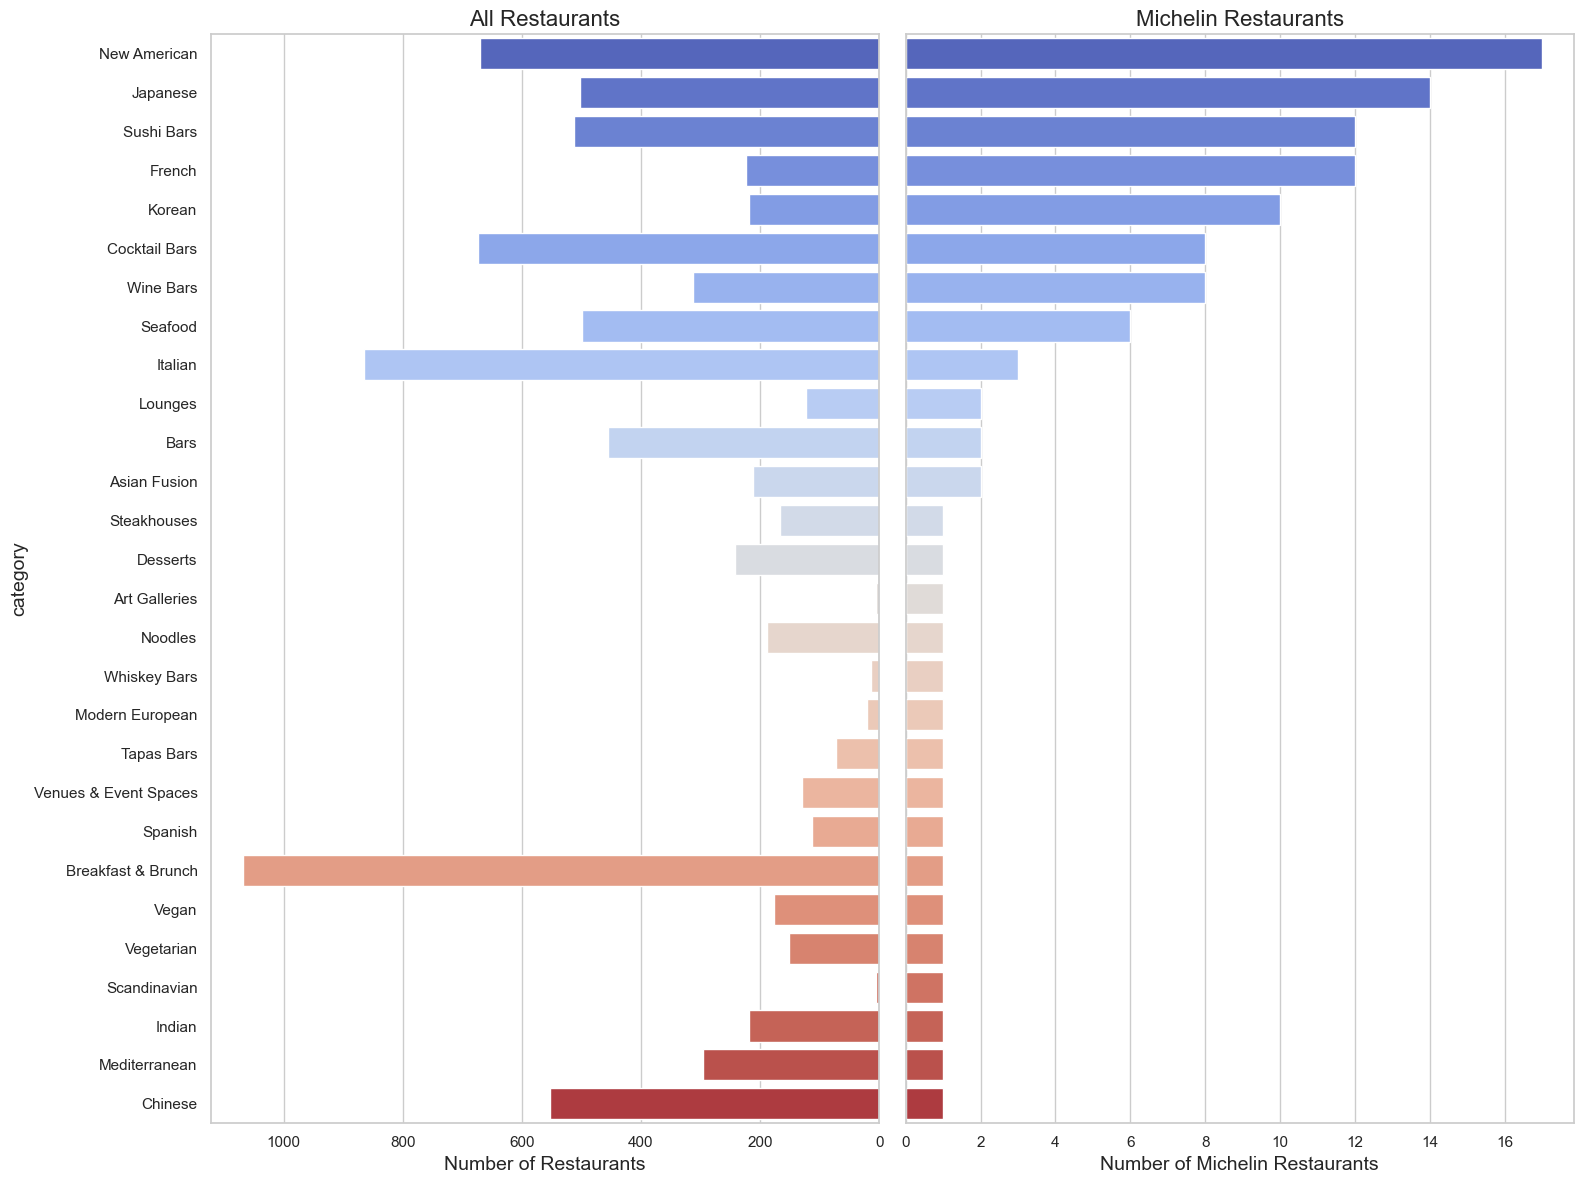

In [28]:
melted_all_df = df_details.melt(id_vars=["id", "name"], value_vars=["category_0", "category_1", "category_2", "category_3"], var_name="category_type", value_name="category").dropna()
melted_michelin_df = michelin_df.melt(id_vars=["id", "name"], value_vars=["category_0", "category_1", "category_2", "category_3"], var_name="category_type", value_name="category").dropna()

category_counts_michelin = melted_michelin_df['category'].value_counts()
sorted_categories = category_counts_michelin.index.tolist()

# Limiting the scope of the all restaurants plot to the same categories and order
melted_all_df_sorted = melted_all_df[melted_all_df['category'].isin(sorted_categories)]
melted_all_df_sorted['category'] = pd.Categorical(melted_all_df_sorted['category'], categories=sorted_categories, ordered=True)

# Preparing the figure layout
fig, axs = plt.subplots(1, 2, figsize=(16, 12), sharey=True, gridspec_kw={'width_ratios': [1, 1]})

# Plot for Michelin restaurants
sns.countplot(y='category', data=melted_michelin_df, ax=axs[1], palette="coolwarm", orient='h', order=sorted_categories)
axs[1].set_title('Michelin Restaurants', fontsize=16)
axs[0].set_ylabel('Category', fontsize=14)
axs[1].set_xlabel('Number of Michelin Restaurants', fontsize=14)

# Plot for all restaurants
sns.countplot(y='category', data=melted_all_df_sorted, ax=axs[0], palette="coolwarm", orient='h', order=sorted_categories)
axs[0].set_title('All Restaurants', fontsize=16)
axs[0].set_xlabel('Number of Restaurants', fontsize=14)
axs[0].invert_xaxis() 
axs[1].set_ylabel('')

plt.tight_layout()
plt.show()

# Michelin restaurants v.s. Non-Michelin restaurants EDA - Numerical Features

## Define some re-usable functions

In [29]:
def feature_stat(df, feature):
    """
    return the df showing number of samples, average of the feature, and the standard deviation of the feature

    :param feature: Name of the feature that we want to compare
    """
    michelin_feature = df[df['is_michelin'] == 1][feature]
    nonmichelin_feature = df[df['is_michelin'] == 0][feature]
    res_df = pd.DataFrame()
    res_df['count'] = [michelin_feature.count(), nonmichelin_feature.count()]
    res_df['mean'] = [michelin_feature.mean(), nonmichelin_feature.mean()]
    res_df['var'] = [michelin_feature.var(), nonmichelin_feature.var()]
    res_df.index = ['Michelin', 'non-Michelin']
    
    return res_df

In [30]:
def welch_ttest(df, feature, mode = 'right'):
    """
    Show the test result and plot of welch t test,
    in order to compare whether there is difference in this feature between Michelin & Non-Michelin restaurants

    :param feature: Name of the feature that we want to compare
    :param mode: 'right' if the alternative hypothesis is the average is higher in Michelin restaurants
                 'left' if the alternative hypothesis is the average is lower in Michelin restaurants
    """

    michelin_feature = df[df['is_michelin'] == 1][feature]
    nonmichelin_feature = df[df['is_michelin'] == 0][feature]

    ttest_res = stats.ttest_ind(michelin_feature, nonmichelin_feature, equal_var = False)
    t = ttest_res.statistic
    degree = ttest_res.df
    print('Test result', ttest_res)

    alpha = 0.005

    # Plot the Welch t-test
    plt.title("Welch t-test")
    # Generate null distribution
    null_dist = np.random.standard_t(df=degree, size=10000)
    bound = np.sort(null_dist)[int((1-alpha)*len(null_dist))]
    if mode == 'left':
        bound = np.sort(null_dist)[int(alpha*len(null_dist))]
        
    # Plot the distribution of test statistics
    plt.hist(null_dist, bins=30, density=True, alpha=0.5, label='Null Distribution')
    plt.axvline(t, color='red', ls='--', label='Observed T-statistic')
    plt.axvline(bound, color='black', ls='--', label='99.5% CI')
    plt.xlabel('Welch\'s t-test statistic')
    plt.ylabel('Density')
    plt.title('Welch\'s t-test: '+feature)
    plt.legend()


In [31]:
def get_correlation_map(df):
    """
    Show the correlation map of the numerical features in the dataframe
    """
    corr_matrix = df.corr(numeric_only=True)
    plt.figure(figsize=(10, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap')
    plt.show()

## 0 Data Description

In [32]:
df_details = pd.read_csv('restaurant_details_michelin_stars.csv', index_col=0)
df_details.describe()

,review_count,rating,phone,distance,coordinates.latitude,coordinates.longitude,location.zip_code,is_michelin,reviews_cnt,elite_reviews_cnt,elite_reviews_perc,user_photo_cnt_avg,user_review_cnt_avg,rating_avg,rating_med,rating_std
count,10877.000000,10877.000000,9.466000e+03,10877.000000,10876.000000,10876.000000,10873.000000,10877.000000,10877.000000,10877.000000,10877.000000,10877.000000,10877.000000,10877.000000,10877.000000,10877.000000
mean,215.190953,3.637906,1.414306e+10,776.487108,40.760034,-73.976907,10059.501977,0.005700,30.494897,11.410040,0.310402,1104.176772,256.831050,3.668073,3.902822,1.101606
std,496.119591,0.906646,2.625724e+09,504.724080,0.039626,0.025065,804.009562,0.075287,20.740287,11.893697,0.256593,4119.449035,383.831461,0.899900,1.164432,0.550721
min,0.000000,0.000000,1.201210e+10,10.852661,40.665103,-74.018764,3276.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,7.000000,3.000000,1.212530e+10,422.643838,40.730628,-73.993618,10011.000000,0.000000,7.000000,1.000000,0.100000,142.060000,105.750000,3.214286,3.500000,0.851409
50%,46.000000,4.000000,1.212889e+10,640.285639,40.753045,-73.983945,10018.000000,0.000000,40.000000,7.000000,0.272727,454.000000,194.880000,3.880000,4.000000,1.200170
75%,220.000000,4.000000,1.646719e+10,992.022654,40.775578,-73.964659,10031.000000,0.000000,50.000000,20.000000,0.480000,938.620000,298.280000,4.280000,5.000000,1.466355
max,15280.000000,5.000000,1.973982e+10,2726.565479,40.886387,-73.893959,90010.000000,1.000000,50.000000,50.000000,1.000000,115226.000000,8462.000000,5.000000,5.000000,2.828427


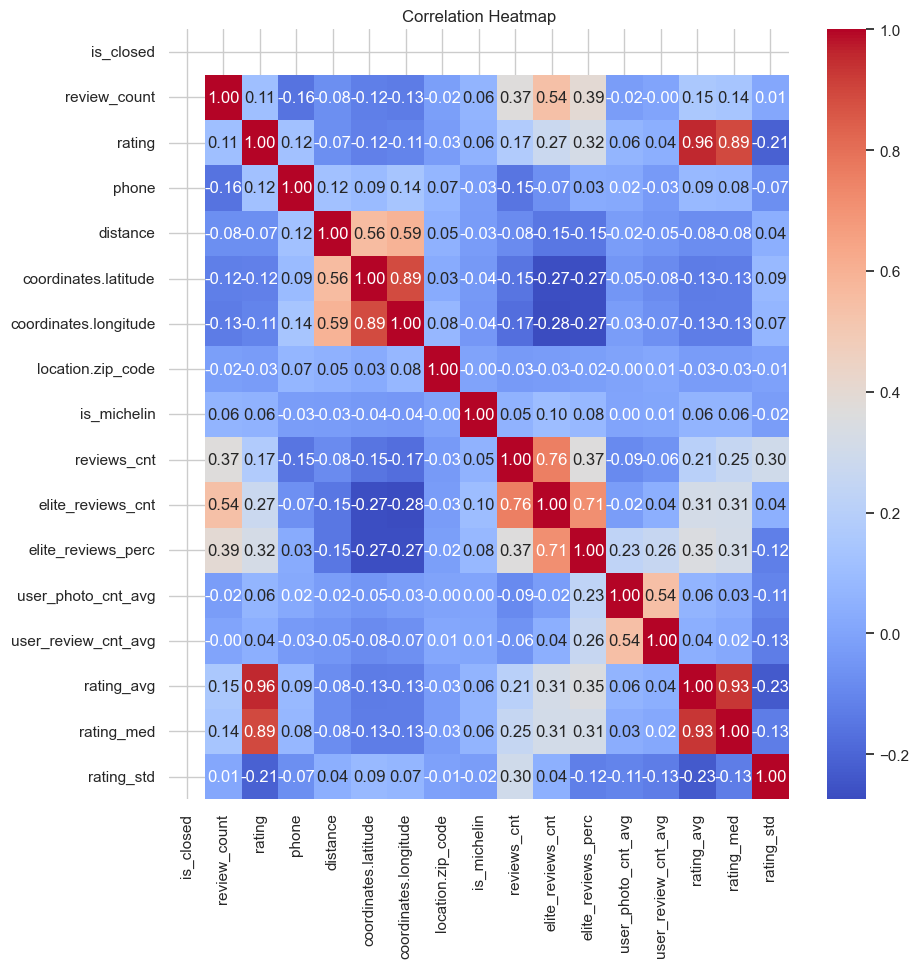

In [33]:
get_correlation_map(df_details)

## 1 Review Counts Distribution
Compare the distribution of the total number of reviews across Michelin & Non-Michelin restaurants

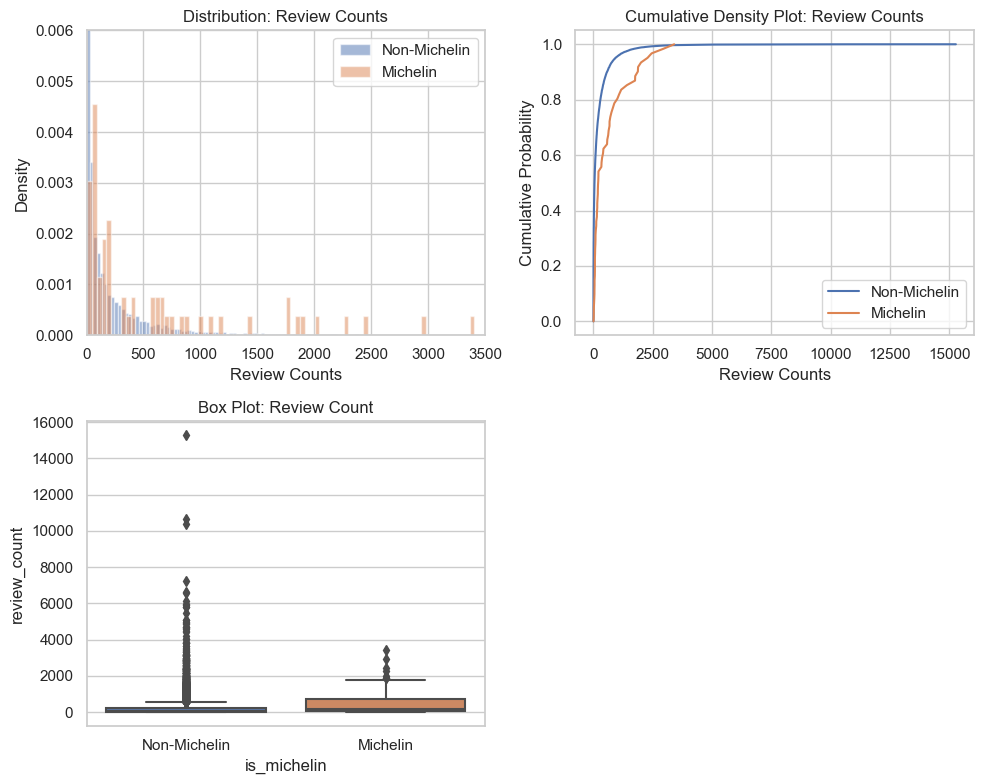

In [34]:
michelin_feature = df_details[df_details['is_michelin']==1]['review_count']
nonmichelin_feature = df_details[df_details['is_michelin']==0]['review_count']

plt.figure(figsize=(10, 8))

# Plot 1: Distribution of review counts with Michelin vs Non-Michelin comparison
plt.subplot(2,2,1)
plt.hist(x = nonmichelin_feature, bins = 500, density = True, alpha=0.5, label = "Non-Michelin")
plt.hist(x = michelin_feature, bins = 80, density = True, alpha=0.5, label = "Michelin")
plt.xlim(0, 3500) # After 3500 the data is sparse so we just ignore that part for better visualization
plt.ylim(0, 0.006) # For density > 0.006 the data is sparse so we just ignore that part for better visualization
plt.ylabel("Density")
plt.xlabel("Review Counts")
plt.title("Distribution: Review Counts")
plt.legend()

# Plot 2: CDF plot of review counts with Michelin vs Non-Michelin comparison
plt.subplot(2,2,2)
sorted_michelin = np.sort(michelin_feature)
sorted_nonmichelin = np.sort(nonmichelin_feature)

# Calculate the cumulative distribution function (CDF)
cumulative_michelin = np.linspace(0, 1, len(sorted_michelin))
cumulative_nonmichelin = np.linspace(0, 1, len(sorted_nonmichelin))

# Plot the cumulative density
plt.plot(sorted_nonmichelin, cumulative_nonmichelin, label='Non-Michelin')
plt.plot(sorted_michelin, cumulative_michelin, label='Michelin')
plt.title('Cumulative Density Plot: Review Counts')
plt.xlabel('Review Counts')
plt.ylabel('Cumulative Probability')
plt.legend()

# Plot 3: Box plot of review counts with Michelin vs Non-Michelin comparison
plt.subplot(2,2,3)
sns.boxplot(x='is_michelin', y='review_count', data=df_details)
plt.xticks([0, 1], ['Non-Michelin', 'Michelin'])
plt.title('Box Plot: Review Count')

plt.tight_layout()
plt.show()

In [35]:
feature_stat(df_details, 'review_count')

,count,mean,var
Michelin,62,599.66129,624680.424379
non-Michelin,10815,212.98687,243169.753480


In [17]:
welch_ttest(df_details, 'review_count')

AttributeError: 'Ttest_indResult' object has no attribute 'df'

According to the significance testing, we reject null hypothesis becuase p-value = 0.00028657247136304746 < 0.005. That is, we can conclude that the sample means are different in two groups, or we say the distribution of reviews count for two groups, “Michelin Restaurants” and “Non-Michelin Restaurants” are significantly having difference under alpha level 0.005. The Michelin reviews counts are higher than the Non-Michelin ones.

## 2 Elite Review Percentage Distribution
Compare the distribution of the percentage of the number Elite reviews over the number of total reviews across Michelin & Non-Michelin restaurants

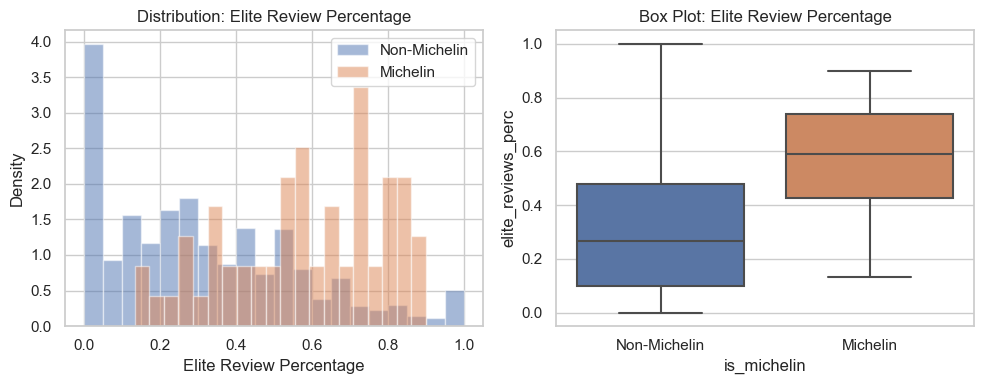

In [36]:
michelin_feature = df_details[df_details['is_michelin']==1]['elite_reviews_perc']
nonmichelin_feature = df_details[df_details['is_michelin']==0]['elite_reviews_perc']

plt.figure(figsize=(10, 4))

# Plot 1: Distribution of Elite Review Percentage with Michelin vs Non-Michelin comparison
plt.subplot(1,2,1)
plt.hist(x = nonmichelin_feature, bins = 20, density = True, alpha=0.5, label = "Non-Michelin")
plt.hist(x = michelin_feature, bins = 20, density = True, alpha=0.5, label = "Michelin")
plt.ylabel("Density")
plt.xlabel("Elite Review Percentage")
plt.title("Distribution: Elite Review Percentage")
plt.legend()

# Plot 2: Box plot of Elite Review Percentage with Michelin vs Non-Michelin comparison
plt.subplot(1,2,2)
sns.boxplot(x='is_michelin', y='elite_reviews_perc', data=df_details)
plt.xticks([0, 1], ['Non-Michelin', 'Michelin'])
plt.title('Box Plot: Elite Review Percentage')

plt.tight_layout()
plt.show()

In [37]:
feature_stat(df_details, 'elite_reviews_perc')

,count,mean,var
Michelin,62,0.584875,0.044132
non-Michelin,10815,0.308828,0.065534


In [38]:
welch_ttest(df_details, 'elite_reviews_perc')

AttributeError: 'Ttest_indResult' object has no attribute 'df'

It also significantly shows that the Michelin restaurants has much higher rate of elite reviews among all reviews. On average, for Michelin restaurant, 58.5% of reviews come from the elite reviewers, indicating that they get a lot more top-notch reviews compared to non-Michelin ones (which get 30.9% of elite reviews).

## 3 Rating Distribution
Compare the distribution of ratings across Michelin & Non-Michelin restaurants

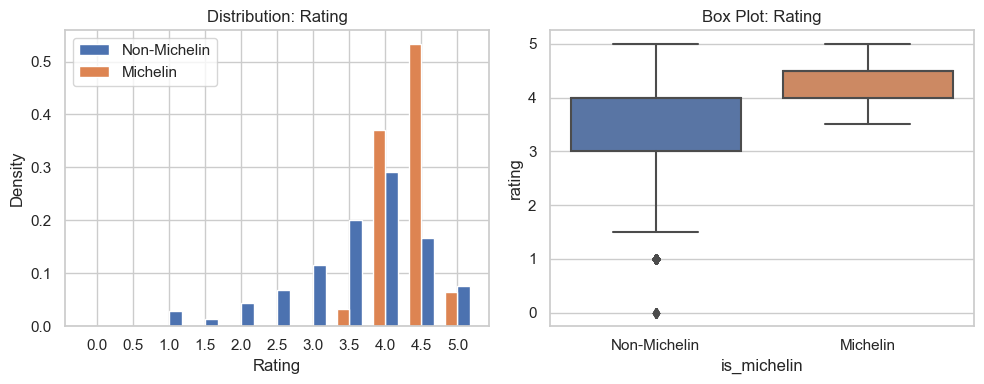

In [39]:
labels = np.arange(0, 5.5, 0.5) # rating has values 0, 0.5, 1, ..., 4.5, 5

michelin_feature = df_details[df_details['is_michelin']==1]['rating'].value_counts()
nonmichelin_feature = df_details[df_details['is_michelin']==0]['rating'].value_counts()

# count the number of samples in each rating category
michelin_rating = [michelin_feature[i] if i in michelin_feature.index else 0 for i in labels]
nonmichelin_rating = [nonmichelin_feature[i] if i in nonmichelin_feature.index else 0 for i in labels]

# calculate the density
michelin_rating = michelin_rating/sum(michelin_rating)
nonmichelin_rating = nonmichelin_rating/sum(nonmichelin_rating)

plt.figure(figsize=(10, 4))

# Plot 1: Distribution of ratings with Michelin vs Non-Michelin comparison
plt.subplot(1,2,1)

bar_width = 0.35
x = np.arange(len(labels)) # Positions of bars on the x-axis
plt.bar(x + bar_width/2, nonmichelin_rating, bar_width, label='Non-Michelin')
plt.bar(x - bar_width/2, michelin_rating, bar_width, label='Michelin')
plt.xlabel('Rating')
plt.ylabel('Density')
plt.title('Distribution: Rating')
plt.xticks(x, labels)
plt.legend()

# Plot 2: Box plot of ratings with Michelin vs Non-Michelin comparison
plt.subplot(1,2,2)
sns.boxplot(x='is_michelin', y='rating', data=df_details)
plt.xticks([0, 1], ['Non-Michelin', 'Michelin'])
plt.title('Box Plot: Rating')

plt.tight_layout()
plt.show()


In [40]:
feature_stat(df_details, 'rating')

,count,mean,var
Michelin,62,4.314516,0.108474
non-Michelin,10815,3.634027,0.823468


In [41]:
welch_ttest(df_details, 'rating')

AttributeError: 'Ttest_indResult' object has no attribute 'df'

Since the p-values is close to zero, Michelin restaurants are significantly having higher ratings. (Yea for sure)

## 4 Rating Standard Deviation Distribution
Compare the distribution of standard deviation of the ratings across Michelin & Non-Michelin restaurants

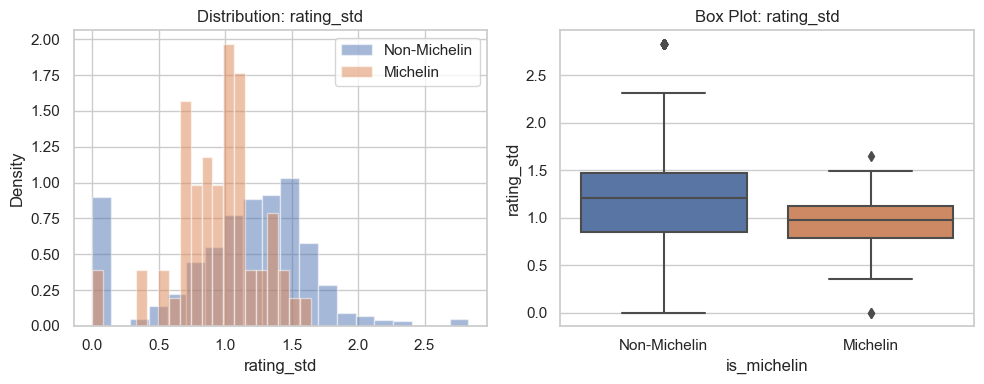

In [42]:
michelin_feature = df_details[df_details['is_michelin']==1]['rating_std']
nonmichelin_feature = df_details[df_details['is_michelin']==0]['rating_std']

plt.figure(figsize=(10, 4))

# Plot 1: Distribution of std of ratings with Michelin vs Non-Michelin comparison
plt.subplot(1,2,1)
plt.hist(x = nonmichelin_feature, bins = 20, density = True, alpha=0.5, label = "Non-Michelin")
plt.hist(x = michelin_feature, bins = 20, density = True, alpha=0.5, label = "Michelin")
plt.ylabel("Density")
plt.xlabel("rating_std")
plt.title("Distribution: rating_std")
plt.legend()

# Plot 2: Box plot of std of ratings with Michelin vs Non-Michelin comparison
plt.subplot(1,2,2)
sns.boxplot(x='is_michelin', y='rating_std', data=df_details)
plt.xticks([0, 1], ['Non-Michelin', 'Michelin'])
plt.title('Box Plot: rating_std')

plt.tight_layout()
plt.show()

In [43]:
feature_stat(df_details, 'rating_std')

,count,mean,var
Michelin,62,0.944166,0.101951
non-Michelin,10815,1.102508,0.304315


In [44]:
welch_ttest(df_details, 'rating_std', mode='left')

AttributeError: 'Ttest_indResult' object has no attribute 'df'

The Michelin-starred restaurants exhibit less variation in their ratings, suggesting more consistent reviews.

## 5 Price Level Comparison
Drawing the bar plot and pie charts to compare the price level between Michelin & Non-Michelin restaurants

In [45]:
df_details['price'] = df_details['price'].fillna('Unknown')
df_price = df_details.groupby(['is_michelin', 'price']).size().reset_index(name = 'count')
price_mapping = {'$': r'\$', '$$': r'\$\$', '$$$': r'\$\$\$', '$$$$': r'\$\$\$\$', 'Unknown': 'Unknown'}
df_price['price'] = df_price['price'].map(price_mapping)
df_price = df_price.set_index('price')
df_price

,is_michelin,count
price,,
\$,0,2033
\$\$,0,3517
\$\$\$,0,706
\$\$\$\$,0,222
Unknown,0,4337
\$\$,1,1
\$\$\$,1,3
\$\$\$\$,1,45
Unknown,1,13


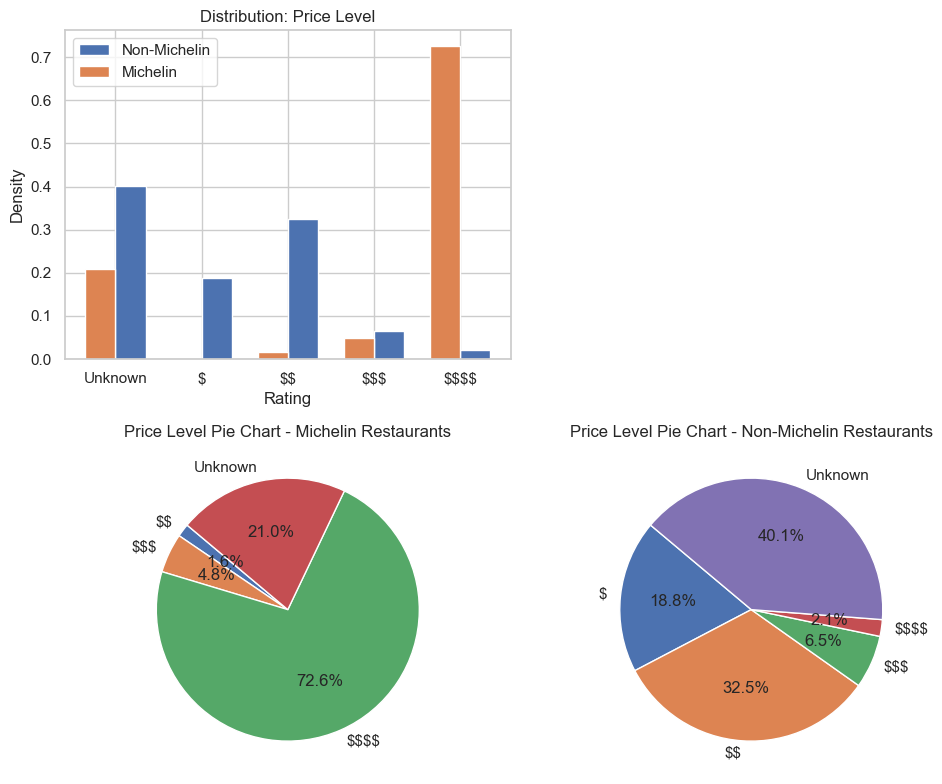

In [46]:
labels = ['Unknown', '\$', '\$\$', '\$\$\$', '\$\$\$\$']

michelin_feature = df_price[df_price['is_michelin']==1]['count']
nonmichelin_feature = df_price[df_price['is_michelin']==0]['count']

michelin_price = [michelin_feature[i] if i in michelin_feature.index else 0 for i in labels]
nonmichelin_price = [nonmichelin_feature[i] if i in nonmichelin_feature.index else 0 for i in labels]

michelin_price = michelin_price/sum(michelin_price)
nonmichelin_price = nonmichelin_price/sum(nonmichelin_price)

plt.figure(figsize=(10, 8))
# Plot 1: Bar plot of the price level with Michelin vs Non-Michelin comparison
plt.subplot(2,2,1)
bar_width = 0.35
x = np.arange(len(labels)) # Positions of bars on the x-axis
plt.bar(x + bar_width/2, nonmichelin_price, bar_width, label='Non-Michelin')
plt.bar(x - bar_width/2, michelin_price, bar_width, label='Michelin')

plt.xlabel('Rating')
plt.ylabel('Density')
plt.title('Distribution: Price Level')
plt.xticks(x, labels)
plt.legend()

# Plot 2: Pie chart of the price level of Michelin restaurants
plt.subplot(2,2,3)
plt.title("Price Level Pie Chart - Michelin Restaurants")
plt.pie(df_price[df_price['is_michelin']==1]['count'], labels= df_price[df_price['is_michelin']==1].index, autopct='%1.1f%%', startangle=140)

# Plot 3: Pie chart of the price level of Non-Michelin restaurants
plt.subplot(2,2,4)
plt.title("Price Level Pie Chart - Non-Michelin Restaurants")
plt.pie(df_price[df_price['is_michelin']==0]['count'], labels= df_price[df_price['is_michelin']==0].index, autopct='%1.1f%%', startangle=140)

# Show plot
plt.tight_layout()
plt.show()

## 6 Cuisine Category Analysis
See what are the top categories for Michelin restaurants and Non-Michelin restaurants

In [47]:
# Julis's Plot

## 7 Trend Over Time

In [22]:
# load the restaurant details data with 'restaurant_reviews.csv' generated from 'data_processing.ipynb'
df_reviews = pd.read_csv('restaurant_reviews_michelin_stars.csv', index_col=0)
df_reviews

FileNotFoundError: [Errno 2] No such file or directory: 'restaurant_reviews_michelin_stars.csv'

In [21]:
df_reviews2 = df_reviews.copy()
df_reviews2 = pd.merge(df_details[['restaurant', 'is_michelin']], df_reviews2, how='inner', on='restaurant')
df_reviews2['localizedDate'] = pd.to_datetime(df_reviews2['localizedDate'])
df_reviews2.set_index('localizedDate', inplace=True)
df_reviews2['year'] = df_reviews2.index.year
df_reviews2['month'] = df_reviews2.index.month

nonmichelin_data = df_reviews2[df_reviews2['is_michelin']==0]
michelin_data = df_reviews2[df_reviews2['is_michelin']==1]

NameError: name 'df_reviews' is not defined

In [31]:
# derive the trend data dataframe
all_trend = df_reviews2.groupby([df_reviews2.index.year, df_reviews2.index.month]).mean(numeric_only=True).reset_index(drop=True)
nonmichelin_trend = nonmichelin_data.groupby([nonmichelin_data.index.year, nonmichelin_data.index.month]).mean(numeric_only=True).reset_index(drop=True)
michelin_trend = michelin_data.groupby([michelin_data.index.year, michelin_data.index.month]).mean(numeric_only=True).reset_index(drop=True)
df_trend = pd.merge(nonmichelin_trend, michelin_trend, on=['year', 'month'], how='outer')[['year', 'month', 'rating_x', 'rating_y']]
df_trend.columns = ['year', 'month', 'NonMichelin_rating','Michelin_rating']
df_trend = pd.merge(df_trend, all_trend, on=['year', 'month'], how='outer')[['year', 'month', 'NonMichelin_rating','Michelin_rating','rating']]

df_reviews_nonmichelin = nonmichelin_data.groupby(['year', 'month']).count()['restaurant'].rename('NonMichelin_review_count').reset_index()
df_reviews_michelin = michelin_data.groupby(['year', 'month']).count()['restaurant'].rename('Michelin_review_count').reset_index()
df_reviews_all = df_reviews2.groupby(['year', 'month']).count()['restaurant'].rename('review_count').reset_index()
df_trend = pd.merge(df_trend, df_reviews_nonmichelin, on=['year', 'month'], how='outer')
df_trend = pd.merge(df_trend, df_reviews_michelin, on=['year', 'month'], how='outer')
df_trend = pd.merge(df_trend, df_reviews_all, on=['year', 'month'], how='outer')
df_trend

,year,month,NonMichelin_rating,Michelin_rating,rating,NonMichelin_review_count,Michelin_review_count,review_count
0,2005.0,5.0,3.333333,NaN,3.333333,3,NaN,3
1,2005.0,6.0,3.500000,NaN,3.500000,2,NaN,2
2,2005.0,7.0,2.500000,NaN,2.500000,4,NaN,4
3,2005.0,8.0,2.000000,NaN,2.000000,1,NaN,1
4,2005.0,9.0,2.800000,NaN,2.800000,5,NaN,5
...,...,...,...,...,...,...,...,...
218,2023.0,7.0,3.986861,4.468571,3.993644,12254,175.0,12429
219,2023.0,8.0,4.003907,4.307692,4.007716,12285,156.0,12441
220,2023.0,9.0,4.017370,4.300000,4.021440,12320,180.0,12500
221,2023.0,10.0,4.034415,4.362445,4.039791,13744,229.0,13973


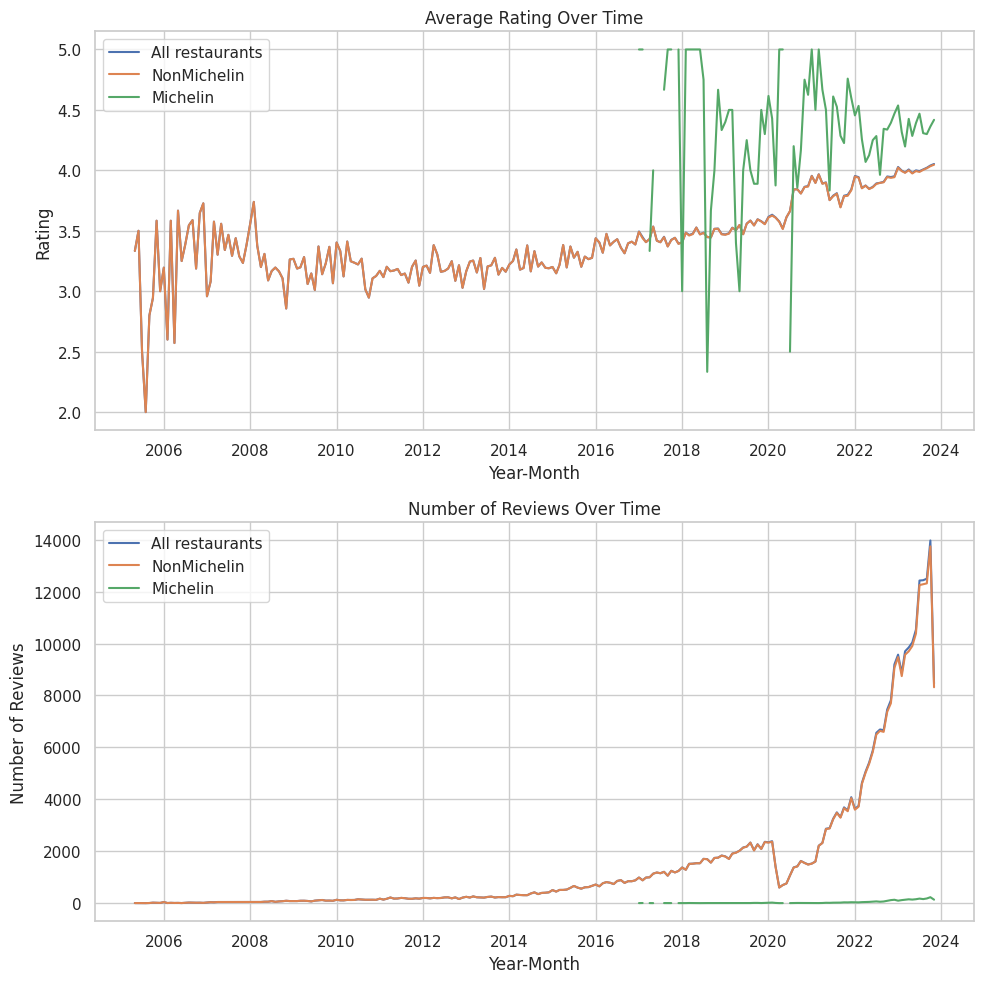

In [32]:
df_trend['year-month'] = pd.to_datetime(df_trend[['year', 'month']].assign(day=1))

plt.figure(figsize=(10, 10))

# Plot 1: average rating over time
plt.subplot(2,1,1)
plt.plot(df_trend['year-month'], df_trend['rating'], label='All restaurants')
plt.plot(df_trend['year-month'], df_trend['NonMichelin_rating'], label='NonMichelin')
plt.plot(df_trend['year-month'], df_trend['Michelin_rating'], label='Michelin')

plt.title('Average Rating Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Rating')
plt.legend()

# Plot 2: number of reviews over time
plt.subplot(2,1,2)
plt.plot(df_trend['year-month'], df_trend['review_count'], label='All restaurants')
plt.plot(df_trend['year-month'], df_trend['NonMichelin_review_count'], label='NonMichelin')
plt.plot(df_trend['year-month'], df_trend['Michelin_review_count'], label='Michelin')

plt.title('Number of Reviews Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Number of Reviews')
plt.legend()

plt.tight_layout()
plt.show()

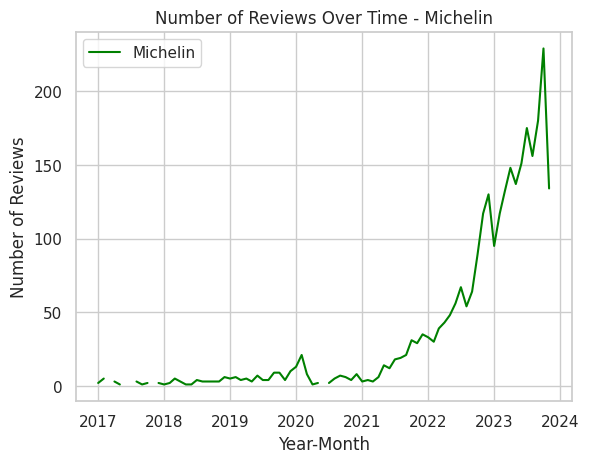

In [33]:
# Zoom in to see the Number of Reviews Over Time - Michelin
plt.plot(df_trend['year-month'], df_trend['Michelin_review_count'], label='Michelin', color = 'green')
plt.title('Number of Reviews Over Time - Michelin')
plt.xlabel('Year-Month')
plt.ylabel('Number of Reviews')
plt.legend()

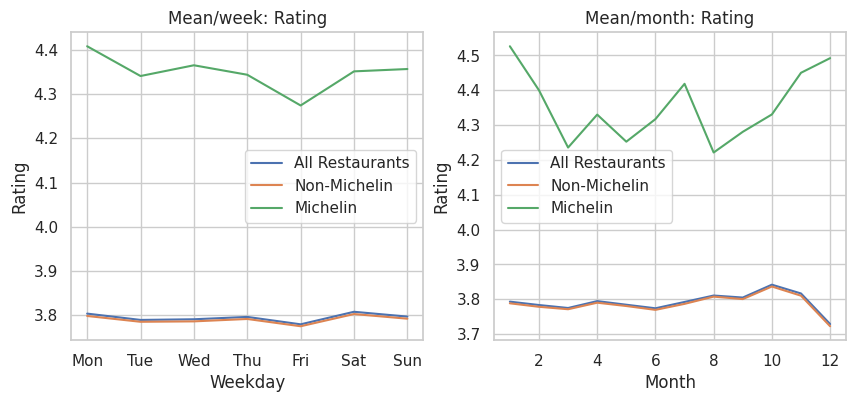

In [34]:
plt.figure(figsize=(10, 4))

# Plot 1: Average rating for each month of the year
plt.subplot(1,2,1)
avg_by_weekday = df_reviews2.groupby(df_reviews2.index.dayofweek).mean(numeric_only=True)['rating']
avg_by_weekday.index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
avg_by_weekday.plot(label='All Restaurants')

avg_by_weekday = nonmichelin_data.groupby(nonmichelin_data.index.dayofweek).mean(numeric_only=True)['rating']
avg_by_weekday.plot(label='Non-Michelin')

avg_by_weekday = michelin_data.groupby(michelin_data.index.dayofweek).mean(numeric_only=True)['rating']
avg_by_weekday.plot(label='Michelin')

plt.xlabel('Weekday')
plt.ylabel('Rating')
plt.title('Mean/week: Rating')
plt.legend()

# Plot 2: Average rating for each weekday of the week
plt.subplot(1,2,2)
avg_by_weekday = df_reviews2.groupby(df_reviews2.index.month).mean(numeric_only=True)['rating']
avg_by_weekday.plot(label='All Restaurants')

avg_by_weekday = nonmichelin_data.groupby(nonmichelin_data.index.month).mean(numeric_only=True)['rating']
avg_by_weekday.plot(label='Non-Michelin')

avg_by_weekday = michelin_data.groupby(michelin_data.index.month).mean(numeric_only=True)['rating']
avg_by_weekday.plot(label='Michelin')

plt.xlabel("Month")
plt.ylabel('Rating')
plt.title('Mean/month: Rating')
plt.legend()
plt.show()

## 8 Elite vs Non-Elite
See the differences between Yelp Elite and Non-Elite

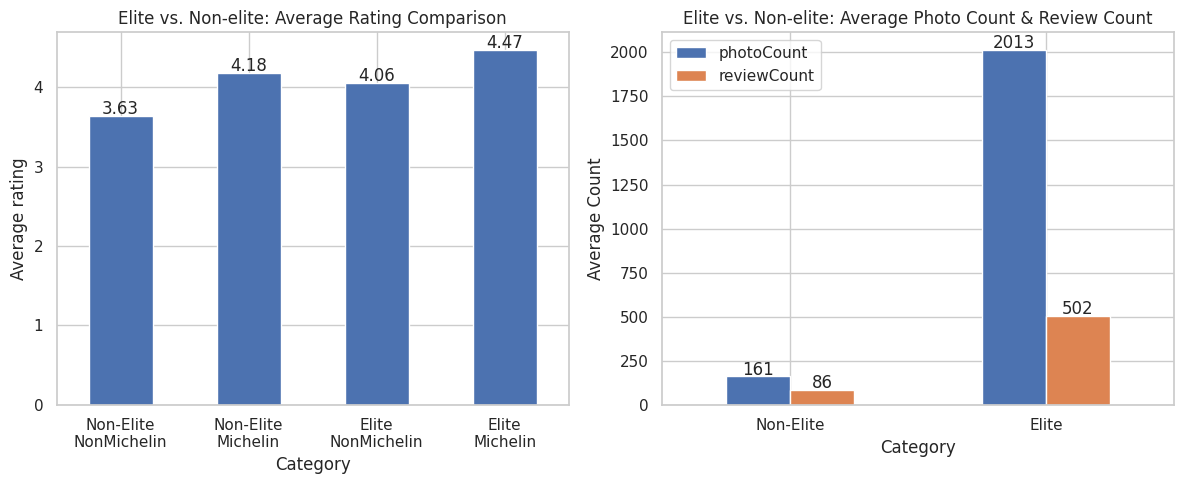

In [35]:
df_elite = df_reviews.copy()
df_elite = pd.merge(df_details[['restaurant', 'is_michelin']], df_elite, how='inner', on='restaurant')
df_elite['is_elite'] = ~df_elite['eliteYear'].isna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Elite vs. Non-elite: Average rating comparison
bar_plot = df_elite.groupby(['is_elite', 'is_michelin']).mean(numeric_only=True)['rating'].plot(kind='bar', ax=ax1)
ax1.set_xticklabels(['Non-Elite\nNonMichelin', 'Non-Elite\nMichelin', 'Elite\nNonMichelin', 'Elite\nMichelin'], rotation=0)
ax1.set_xlabel('Category')
ax1.set_ylabel('Average rating')
# Annotate each bar with its value
for p in bar_plot.patches:
    bar_plot.annotate(str(round(p.get_height(), 2)), (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center', xytext=(0, 5), textcoords='offset points')
ax1.set_title("Elite vs. Non-elite: Average Rating Comparison")

# Plot 2: Elite vs. Non-elite: Average photoCount & reviewCount
df_elite[['photoCount', 'reviewCount']] = df_elite[['photoCount', 'reviewCount']].apply(pd.to_numeric) # change to numerical data
bar_plot = df_elite.groupby(['is_elite']).mean(numeric_only=True)[['photoCount', 'reviewCount']].plot(kind='bar', ax=ax2)
ax2.set_xticklabels(['Non-Elite', 'Elite'], rotation=0)
ax2.set_xlabel('Category')
ax2.set_ylabel('Average Count')
ax2.set_title("Elite vs. Non-elite: Average Photo Count & Review Count")
# Annotate each bar with its value
for p in bar_plot.patches:
    bar_plot.annotate(str(round(p.get_height())), (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

In [36]:
df_elite.groupby(['is_elite']).mean(numeric_only=True)

,is_michelin,photoCount,reviewCount,eliteYear,rating
is_elite,,,,,
False,0.005501,160.979555,85.603572,NaN,3.635183
True,0.013521,2013.040232,502.300122,2023.0,4.061069
